# Subjective Verbs

This notebook seeks to merge ideas in the 2 SV pair notebooks.

<div class="alert alert-block alert-info"> 
    <p>A note about the naming of variables below:</p>
    <ul>
        <li><code>m</code> and <code>w</code> represent the subcorpus, men or women speakers</li>
        <li><code>pp</code> stands for personal pronouns, usually "he," "she," and "I" here.
        <li><code>svo</code> signifies that the complete SVO-triplet is used</li>
        <li><code>sv</code> signifies that just the subject-verb pairs are being used</li>
    </ul>   
</div>

What we want to explore is both the usual ways that speakers (men or women) pair the pronouns *he*, *she*, *i* with verbs and also, perhaps, the significant pairings. The usual way can be approached via **counts**, which we have visualized in a separate notebook with Sankey plots.

Relative frequencies would let us compare across the two subcorpora ... or would this be approached better by some form of TF-IDF? (And would we need to determine some sort of lower threshold of the number of sentences in which a verb must occur? We're not interested in verb only used in a single sentence but verbs used often in a pairing in one subcorpus and not in the other.)

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# LOAD DATAFRAMES
# the `lem` suffix indicates the verbs have been lemmatized
svos_m = pd.read_csv("../output/svos_m_lem.csv", index_col=0)
svos_w = pd.read_csv("../output/svos_w_lem.csv", index_col=0)

# Save the SVO count for each corpus for calculating relative frequencies
m_svo_count = svos_m.shape[0]
w_svo_count = svos_w.shape[0]

# Output something to check our efforts
print(m_svo_count, w_svo_count)

80460 26610


## SV Pairs with "She", "He", and "I"

In [2]:
# Create a list of the pronouns we want to see
pronouns = ["he", "she", "i"]

# Function to retrive the count the number of times subjects,
# here a list of pronouns, are paired with verbs
def svPairs (df, pplist):    
    temp = df[df["subject"].isin(
        pplist)].value_counts(
        subset=['subject', 'verb']).reset_index()
    # Re-label the new column from "0" to something human-readable
    temp.rename(columns={0:'v_freq'}, inplace=True)
    # Add a column with relative frequency
    temp['v_rfreq'] = temp['v_freq'] / df.shape[0]
    return temp

In [3]:
m_pp_v = svPairs(svos_m, pronouns)
w_pp_v = svPairs(svos_w, pronouns)

print(m_pp_v.shape)
print(w_pp_v.shape)

# m_pp_v.to_csv("../output/m_pp_v.csv")
# w_pp_v.to_csv("../output/w_pp_v.csv")

(1723, 4)
(1069, 4)


## Subjects as Verb Features

In the cells below, we … 

1. **create 6 distinct dataframes**, one each for men and women speakers and the three pronouns.
2. **transpose each "subjective" dataframe** into a single row with the verbs associated with as columns and their relative frequencies as values.
3. **stack those rows** to get a unified dataframe with all 6 subject positions and verbs associated with them.
4. **transpose unified dataframe** to have the features as rows and the speaker-pronoun documents as columns (so we can do some math on the features). I.e., `verbs` dataframe below.

<div class="alert alert-block alert-warning">    
    <p>There is a lot of repetition here. No doubt there are not only better ways to do this in terms of individual lines of code but also without as many lines of repetitious code as there are here.</p>
    </div>

<div class="alert alert-block alert-info">
**NOTE**: Possible threshold 0.002 (0.2%) frequency represents at least 38 occurrences in the men's subcorpus and 15 in the women's.
</div>

In [4]:
# Filter for pronoun and drop the un-needed columns
m_he = m_pp_v.loc[(m_pp_v['subject'] == 'he')].drop(columns=["subject","v_rfreq"])
w_he = w_pp_v.loc[(w_pp_v['subject'] == 'he')].drop(columns=["subject","v_rfreq"])

# Repeat for "she"
m_she = m_pp_v.loc[(m_pp_v['subject'] == 'she')].drop(columns=["subject","v_rfreq"])
w_she = w_pp_v.loc[(w_pp_v['subject'] == 'she')].drop(columns=["subject","v_rfreq"])

# Repeat for "i"
m_i = m_pp_v.loc[(m_pp_v['subject'] == 'i')].drop(columns=["subject","v_rfreq"])
w_i = w_pp_v.loc[(w_pp_v['subject'] == 'i')].drop(columns=["subject","v_rfreq"])

# Print counts & preview a dataframe
print(f"m_he:  {m_he.shape[0]}, w_he:  {w_he.shape[0]}")
print(f"m_she: {m_she.shape[0]}, w_she: {w_she.shape[0]}")
print(f"m_i:   {m_i.shape[0]}, w_i:   {w_i.shape[0]}")
print("\n w_i looks like:")
print(w_i.head())

m_he:  514, w_he:  246
m_she: 245, w_she: 221
m_i:   964, w_i:   602

 w_i looks like:
   verb  v_freq
0  have     586
1  want     424
2    go     330
3    do     226
4   get     203


In [5]:
# This function ...
def makestackable (df, indexname):
    df_T = df.transpose()
    df_T.columns = df_T.iloc[0]
    df_T.drop(index=df_T.index[0], axis=0, inplace=True)
    df_T.index = [indexname]
    return df_T

# We use the function to create 6 dataframes
m_it = makestackable(m_i, "m_i")
w_it = makestackable(w_i, "w_i")
m_het = makestackable(m_he, "m_he")
w_het = makestackable(w_he, "w_he")
m_shet = makestackable(m_she, "m_she")
w_shet = makestackable(w_she, "w_she")

# ... that we then "stack" together 
# with the verbs as columns and the counts as values
concatenated = pd.concat([w_it, m_it, w_het, m_het, w_shet, m_shet])
concatenated.fillna(0, inplace=True)

# View the results
concatenated.head(6)

verb,have,want,go,do,get,tell,like,know,start,love,...,disturb,dry,emanate,enlighten,capitulate,acquire,admonish,age,aspire,bed
w_i,586,424,330,226,203,169,160,154,145,137,...,0,0,0,0,0,0,0,0,0,0
m_i,1318,1210,1076,650,586,326,462,274,377,271,...,0,0,0,0,0,0,0,0,0,0
w_he,80,20,32,29,19,16,7,4,12,4,...,0,0,0,0,0,0,0,0,0,0
m_he,232,71,78,111,90,58,14,27,42,5,...,0,0,0,0,0,0,0,0,0,0
w_she,63,11,22,33,20,18,6,6,9,10,...,0,0,0,0,0,0,0,0,0,0
m_she,94,32,34,41,24,20,5,10,17,4,...,1,1,1,1,1,1,1,1,1,1


In [6]:
# Having done the work above, we now rotate the dataframe again
# in order to have the speaker-pronouns as columns and the verbs as rows
verbs = concatenated.transpose()
verbs.head()

,w_i,m_i,w_he,m_he,w_she,m_she
verb,,,,,,
have,586,1318,80,232,63,94
want,424,1210,20,71,11,32
go,330,1076,32,78,22,34
do,226,650,29,111,33,41
get,203,586,19,90,20,24


### The TF-IDF Part

We are going to treat each of the speaker-pronoun columns as a document, so that we can explore which verbs are evenly distributed across the pairings and which differentiate the actions available to a subject.

In [7]:
# We need totals both by term (rows) and by document (columns)
# A peculiarity of pandas means we need to get rows first, then columns

# Totals per verb:
verbs["total"] = verbs.sum(axis = 1)

# Totals per document
doc_totals = verbs.sum(axis = 0)

# To hold our totals
new_verbs = verbs.copy()

# View the total number of s-v pairs per pronoun
doc_totals

w_i       6185
m_i      15440
w_he       757
m_he      2548
w_she      643
m_she      848
total    26421
dtype: int64

In [8]:
# Get TF by "document"
verbs = verbs/doc_totals

In [9]:
# Reclaim our totals:
verbs["total"] = new_verbs["total"]

In [10]:
verbs

,w_i,m_i,w_he,m_he,w_she,m_she,total
verb,,,,,,,
have,0.094745,0.085363,0.105680,0.091052,0.097978,0.110849,2373
want,0.068553,0.078368,0.026420,0.027865,0.017107,0.037736,1768
go,0.053355,0.069689,0.042272,0.030612,0.034215,0.040094,1572
do,0.036540,0.042098,0.038309,0.043564,0.051322,0.048349,1090
get,0.032821,0.037953,0.025099,0.035322,0.031104,0.028302,942
...,...,...,...,...,...,...,...
acquire,0.000000,0.000000,0.000000,0.000000,0.000000,0.001179,1
admonish,0.000000,0.000000,0.000000,0.000000,0.000000,0.001179,1
age,0.000000,0.000000,0.000000,0.000000,0.000000,0.001179,1


In [11]:
# establish that we only want to work on the counts
# for each pronoun and not the total
cols = verbs.columns
cols = list(cols)[:-1]

# the TFIDF part
for col in cols:
    verbs[col] = (1/new_verbs["total"])*verbs[col]
    
# let's see it
verbs

,w_i,m_i,w_he,m_he,w_she,m_she,total
verb,,,,,,,
have,0.000040,0.000036,0.000045,0.000038,0.000041,0.000047,2373
want,0.000039,0.000044,0.000015,0.000016,0.000010,0.000021,1768
go,0.000034,0.000044,0.000027,0.000019,0.000022,0.000026,1572
do,0.000034,0.000039,0.000035,0.000040,0.000047,0.000044,1090
get,0.000035,0.000040,0.000027,0.000037,0.000033,0.000030,942
...,...,...,...,...,...,...,...
acquire,0.000000,0.000000,0.000000,0.000000,0.000000,0.001179,1
admonish,0.000000,0.000000,0.000000,0.000000,0.000000,0.001179,1
age,0.000000,0.000000,0.000000,0.000000,0.000000,0.001179,1


In [12]:
verbsy = verbs.drop('total', axis=1)
verbsy.style.background_gradient(axis=None, cmap='YlGnBu')

,w_i,m_i,w_he,m_he,w_she,m_she
verb,,,,,,
have,0.000040,0.000036,0.000045,0.000038,0.000041,0.000047
want,0.000039,0.000044,0.000015,0.000016,0.000010,0.000021
go,0.000034,0.000044,0.000027,0.000019,0.000022,0.000026
do,0.000034,0.000039,0.000035,0.000040,0.000047,0.000044
get,0.000035,0.000040,0.000027,0.000037,0.000033,0.000030
tell,0.000045,0.000035,0.000035,0.000038,0.000046,0.000039
like,0.000040,0.000046,0.000014,0.000008,0.000014,0.000009
know,0.000052,0.000037,0.000011,0.000022,0.000020,0.000025
start,0.000039,0.000041,0.000026,0.000027,0.000023,0.000033


<AxesSubplot:ylabel='verb'>

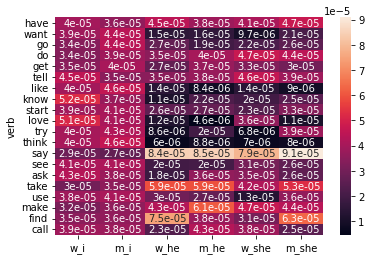

In [13]:
sns.heatmap(verbsy.head(20), annot=True)

### Weighted Class TF-IDF

[How to correctly use TF-IDF with imbalanced data — DeepwizAI](https://www.deepwizai.com/projects/how-to-correctly-use-tf-idf-with-imbalanced-data)

### TF-IDF with Normalized Frequencies

In [14]:
# Filter for pronoun and drop the un-needed columns
m_he = m_pp_v.loc[(m_pp_v['subject'] == 'he')].drop(columns=["subject","v_freq"])
w_he = w_pp_v.loc[(w_pp_v['subject'] == 'he')].drop(columns=["subject","v_freq"])

# Repeat for "she"
m_she = m_pp_v.loc[(m_pp_v['subject'] == 'she')].drop(columns=["subject","v_freq"])
w_she = w_pp_v.loc[(w_pp_v['subject'] == 'she')].drop(columns=["subject","v_freq"])

# Repeat for "i"
m_i = m_pp_v.loc[(m_pp_v['subject'] == 'i')].drop(columns=["subject","v_freq"])
w_i = w_pp_v.loc[(w_pp_v['subject'] == 'i')].drop(columns=["subject","v_freq"])

m_it = makestackable(m_i, "m_i")
w_it = makestackable(w_i, "w_i")
m_het = makestackable(m_he, "m_he")
w_het = makestackable(w_he, "w_he")
m_shet = makestackable(m_she, "m_she")
w_shet = makestackable(w_she, "w_she")

concatenated = pd.concat([w_it, m_it, m_het, w_het, m_shet, w_shet])
concatenated.fillna(0, inplace=True)
concatenated.head(6)

verbs = concatenated.transpose()


# get totals per verb
verbs["total"] = verbs.sum(axis = 1)

# establish that we only want to work on the counts
# for each pronoun and not the total
cols = verbs.columns
cols = list(cols)[:-1]

# the TFIDF part
for col in cols:
    verbs[col] = (1/verbs["total"])*verbs[col]
    
# Display / Visualization
verbsy = verbs.drop('total', axis=1)
verbsy.style.background_gradient(axis=None, cmap='YlGnBu')

,w_i,m_i,m_he,w_he,m_she,w_she
verb,,,,,,
have,0.460435,0.342493,0.060287,0.062858,0.024427,0.049501
want,0.476812,0.450020,0.026406,0.022491,0.011901,0.012370
go,0.424765,0.458049,0.033204,0.041189,0.014474,0.028318
do,0.408503,0.388566,0.066355,0.052418,0.024510,0.059649
get,0.428717,0.409295,0.062861,0.040126,0.016763,0.042238
tell,0.502061,0.320297,0.056985,0.047532,0.019650,0.053474
like,0.481815,0.460115,0.013943,0.021079,0.004980,0.018068
know,0.577093,0.339578,0.033462,0.014989,0.012393,0.022484
start,0.467447,0.401949,0.044779,0.038685,0.018125,0.029014
